In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
olympdata = pd.read_excel("olympics-data.xlsx")

#quick overview of the dataset: datatypes, null and non-null values 
olympdata.info()

# central stats to check ranges, average and potential outliers
olympdata.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145500 entries, 0 to 145499
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   athlete_id    145500 non-null  int64  
 1   name          145500 non-null  object 
 2   born_date     143693 non-null  object 
 3   born_city     110908 non-null  object 
 4   born_region   110908 non-null  object 
 5   born_country  110908 non-null  object 
 6   NOC           145499 non-null  object 
 7   height_cm     106651 non-null  float64
 8   weight_kg     102070 non-null  float64
 9   died_date     33940 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 11.1+ MB


,athlete_id,height_cm,weight_kg
count,145500.000000,106651.000000,102070.000000
mean,73686.188955,176.333724,71.890996
std,42868.960158,10.380282,14.465540
min,1.000000,127.000000,25.000000
25%,36663.750000,170.000000,62.000000
50%,73302.500000,176.000000,70.000000
75%,110306.250000,183.000000,80.000000
max,149814.000000,226.000000,198.000000


In [3]:
# taking a quick look at the first five rows in our dataset

olympdata.head()

,athlete_id,name,born_date,born_city,born_region,born_country,NOC,height_cm,weight_kg,died_date
0,1,Jean-François Blanchy,1886-12-12,Bordeaux,Gironde,FRA,France,NaN,NaN,1960-10-02
1,2,Arnaud Boetsch,1969-04-01,Meulan,Yvelines,FRA,France,183.0,76.0,NaN
2,3,Jean Borotra,1898-08-13,Biarritz,Pyrénées-Atlantiques,FRA,France,183.0,76.0,1994-07-17
3,4,Jacques Brugnon,1895-05-11,Paris VIIIe,Paris,FRA,France,168.0,64.0,1978-03-20
4,5,Albert Canet,1878-04-17,Wandsworth,England,GBR,France,NaN,NaN,1930-07-25


# Data Cleaning and Preprocessing

In [4]:
# 1. convert dates to datetime 
olympdata['born_date'] = pd.to_datetime(olympdata['born_date'])
olympdata['died_date'] = pd.to_datetime(olympdata['died_date'])

olympdata.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145500 entries, 0 to 145499
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   athlete_id    145500 non-null  int64         
 1   name          145500 non-null  object        
 2   born_date     143693 non-null  datetime64[ns]
 3   born_city     110908 non-null  object        
 4   born_region   110908 non-null  object        
 5   born_country  110908 non-null  object        
 6   NOC           145499 non-null  object        
 7   height_cm     106651 non-null  float64       
 8   weight_kg     102070 non-null  float64       
 9   died_date     33940 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), object(5)
memory usage: 11.1+ MB


In [5]:
# 2. Handling Nan Values

olympdata.isna().sum()

# starting with NOC, since there is only one Nan value, we can drop that particular row 
olympdata.dropna(subset = ['NOC'], inplace = True)

In [6]:
# Creating 2 new columns for Year of Birth and Year of Death for a more accurate analysis

olympdata['birth_year'] = olympdata['born_date'].dt.year
olympdata['death_year'] = olympdata['died_date'].dt.year

# Removing the columns of born_date and died_date for easier reading
cols = ['born_date', 'died_date']
olympdata.drop(cols, axis =1, inplace = True)


In [7]:
# creating an age column for future analysis

# if the data is not null or is 0, there is a death year given meaning that the athlete has passed away.
# Hence, the data will show -1

current_year = 2025
olympdata['age'] = np.where(
    (olympdata['death_year'].notna()) | (olympdata['death_year'] == 0),
    -1,
    current_year - olympdata['birth_year'])

In [8]:
# There is another dataset that I want to merge which carries results

results = pd.read_csv('Olymps_results.csv')

results = results.drop(columns=['team'])

# replace the NaN values in medals with "No Medals Won"

results['medal'] = results['medal'].fillna('No Medal')

# merge the data on the column that is in both - 'athlete_id'

combined = pd.merge(olympdata, results, on = 'athlete_id', how = 'left')

# drop the unnecessary columns which are not needed for future analysis 

combined.drop(columns = ['as', 'born_city', 'born_region'], inplace = True)

# changing the float value to int

cols = ['year' , 'birth_year', 'death_year']
        
combined[cols] = combined[cols].fillna(0).astype(int)

# The Olympics were cancalled in 1940 and 1944 due to World War II, so we can remove that data 

combined = combined[~combined['year'].isin(['1940','1944'])]

# dropping duplicates 

combined = combined.drop_duplicates(subset=['athlete_id', 'year', 'event'])

# rename 

combined.rename(columns={'discipline' : 'sport'}, inplace =True)

# Since we already have its duplicate called 'NOC', we can drop the 'noc' column
combined.drop(columns = ['noc'], inplace = True)   

combined

,athlete_id,name,born_country,NOC,height_cm,weight_kg,birth_year,death_year,age,year,type,sport,event,place,tied,medal
0,1,Jean-François Blanchy,FRA,France,NaN,NaN,1886,1960,-1.0,1912,Summer,Tennis,"Singles, Men (Olympic)",17.0,True,No Medal
1,1,Jean-François Blanchy,FRA,France,NaN,NaN,1886,1960,-1.0,1912,Summer,Tennis,"Doubles, Men (Olympic)",NaN,False,No Medal
2,1,Jean-François Blanchy,FRA,France,NaN,NaN,1886,1960,-1.0,1920,Summer,Tennis,"Singles, Men (Olympic)",32.0,True,No Medal
3,1,Jean-François Blanchy,FRA,France,NaN,NaN,1886,1960,-1.0,1920,Summer,Tennis,"Doubles, Mixed (Olympic)",8.0,True,No Medal
4,1,Jean-François Blanchy,FRA,France,NaN,NaN,1886,1960,-1.0,1920,Summer,Tennis,"Doubles, Men (Olympic)",4.0,False,No Medal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308640,149222,Polina Luchnikova,RUS,ROC,167.0,61.0,2002,0,23.0,0,NaN,NaN,NaN,NaN,NaN,NaN
308641,149223,Valeriya Merkusheva,RUS,ROC,168.0,65.0,1999,0,26.0,0,NaN,NaN,NaN,NaN,NaN,NaN
308642,149224,Yuliya Smirnova,RUS,ROC,163.0,55.0,1998,0,27.0,0,NaN,NaN,NaN,NaN,NaN,NaN
308643,149225,André Foussard,FRA,France,166.0,NaN,1899,1986,-1.0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# For NaN values in height and weight columns: fill in using median height and weight for the same sport and gender

# but first, we will have to create a gender column where we will take our data from the 'event' column

combined['sex'] = combined['event'].apply(
    lambda x: '-' if pd.isna(x) else ('Men' if 'Men' in x else ('Women' if 'Women' in x else '-'))
)

combined['height_cm'] = combined.groupby(['sport','sex'])['height_cm'].transform(lambda x: x.fillna(x.median()))
combined['weight_kg'] = combined.groupby(['sport','sex'])['weight_kg'].transform(lambda x: x.fillna(x.median()))

# to avoid different numbers for the same athlete, we will go with the highest value
combined['height_cm'] = combined.groupby('name')['height_cm'].transform('max') 
combined['weight_kg'] = combined.groupby('name')['weight_kg'].transform('max')

combined

,athlete_id,name,born_country,NOC,height_cm,weight_kg,birth_year,death_year,age,year,type,sport,event,place,tied,medal,sex
0,1,Jean-François Blanchy,FRA,France,185.0,79.0,1886,1960,-1.0,1912,Summer,Tennis,"Singles, Men (Olympic)",17.0,True,No Medal,Men
1,1,Jean-François Blanchy,FRA,France,185.0,79.0,1886,1960,-1.0,1912,Summer,Tennis,"Doubles, Men (Olympic)",NaN,False,No Medal,Men
2,1,Jean-François Blanchy,FRA,France,185.0,79.0,1886,1960,-1.0,1920,Summer,Tennis,"Singles, Men (Olympic)",32.0,True,No Medal,Men
3,1,Jean-François Blanchy,FRA,France,185.0,79.0,1886,1960,-1.0,1920,Summer,Tennis,"Doubles, Mixed (Olympic)",8.0,True,No Medal,-
4,1,Jean-François Blanchy,FRA,France,185.0,79.0,1886,1960,-1.0,1920,Summer,Tennis,"Doubles, Men (Olympic)",4.0,False,No Medal,Men
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308640,149222,Polina Luchnikova,RUS,ROC,NaN,NaN,2002,0,23.0,0,NaN,NaN,NaN,NaN,NaN,NaN,-
308641,149223,Valeriya Merkusheva,RUS,ROC,NaN,NaN,1999,0,26.0,0,NaN,NaN,NaN,NaN,NaN,NaN,-
308642,149224,Yuliya Smirnova,RUS,ROC,NaN,NaN,1998,0,27.0,0,NaN,NaN,NaN,NaN,NaN,NaN,-
308643,149225,André Foussard,FRA,France,NaN,NaN,1899,1986,-1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,-


In [10]:
# Another file that I want to merge contains the host countries

host = pd.read_excel('Host_Countries.xlsx')

# merge this file into our existing combined file based on year

host.rename(columns = {'Year': 'year', 'Country' :'host_country'}, inplace = True)

combined = pd.merge(combined, host, on = 'year', how = 'left')

combined.head()

,athlete_id,name,born_country,NOC,height_cm,weight_kg,birth_year,death_year,age,year,type,sport,event,place,tied,medal,sex,host_country
0,1,Jean-François Blanchy,FRA,France,185.0,79.0,1886,1960,-1.0,1912,Summer,Tennis,"Singles, Men (Olympic)",17.0,True,No Medal,Men,Sweden
1,1,Jean-François Blanchy,FRA,France,185.0,79.0,1886,1960,-1.0,1912,Summer,Tennis,"Doubles, Men (Olympic)",NaN,False,No Medal,Men,Sweden
2,1,Jean-François Blanchy,FRA,France,185.0,79.0,1886,1960,-1.0,1920,Summer,Tennis,"Singles, Men (Olympic)",32.0,True,No Medal,Men,Belgium
3,1,Jean-François Blanchy,FRA,France,185.0,79.0,1886,1960,-1.0,1920,Summer,Tennis,"Doubles, Mixed (Olympic)",8.0,True,No Medal,-,Belgium
4,1,Jean-François Blanchy,FRA,France,185.0,79.0,1886,1960,-1.0,1920,Summer,Tennis,"Doubles, Men (Olympic)",4.0,False,No Medal,Men,Belgium


# Quick Summary of Pre-Processed Data

After preprocessing, the dataset was cleaned and standardized for analysis. Columns were converted to appropriate data types, and missing values were handled. For deeper analysis of athlete longevity and consistency, new columns for birth and death years were created while redundant date columns were dropped. Missing values in height and weight were imputed using the average values grouped by sport and gender, ensuring fairer comparisons across athletes.

# Exploratory Data Analysis

# Part 1: What makes a sport successful? 

1. Which sport and event had the most winners?

The Sport and The Event with The Most Winners: ('Football (Football)', 'Football, Men (Olympic)') with a value of 1235 athletes


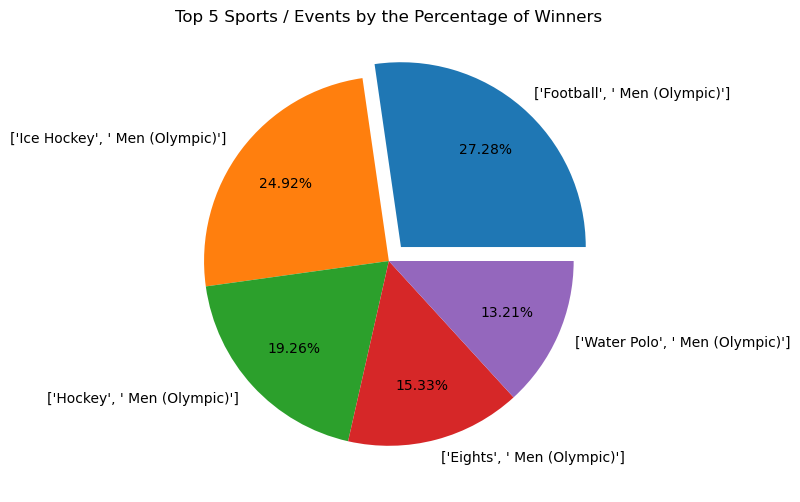

In [11]:
# 1. - creating a function that will give us a description of the data

def summarize_max(frame, name = 'None', val = 'None', description = 'Maximum'):
    if isinstance(frame, pd.Series):
        max_ind = frame.idxmax()
        max_val = frame[max_ind]
        print(f'{description}: {max_ind} with a value of {max_val} athletes')
    else:
        # For DataFrame 
        max_row = frame[val].idxmax()
        max_label = frame.loc[max_row, name]
        max_val = frame.loc[max_row, val]
        print(f'{description}: {max_label} with a value of {max_val} athletes')
    return max_ind, max_val
                
winners = combined[combined['medal'].isin(['Gold','Silver','Bronze'])]
winners_counts = winners.groupby(['sport', 'event'])['name'].nunique().sort_values(ascending = False)
max_event, max_winners = summarize_max(winners_counts, description = 'The Sport and The Event with The Most Winners')

top_events = winners_counts.head(5)

explodes = [0.1 if i == top_events.max() else 0 for i in top_events]
labels = [f'{events.split(',')[0:2]}' for sport, events in top_events.index]
plt.figure(figsize=(12,6))
plt.pie(top_events, 
        labels = labels,
        explode = explodes, 
        autopct = '%.2f%%',
        pctdistance = 0.7)
plt.title('Top 5 Sports / Events by the Percentage of Winners')
plt.show()


2. Which sports dominate Summer and Winter seasons, accroding to the medal count?

Top sports by season:
                      sport    type  medal
7                 Athletics  Summer   4229
76  Speed Skating (Skating)  Winter    797


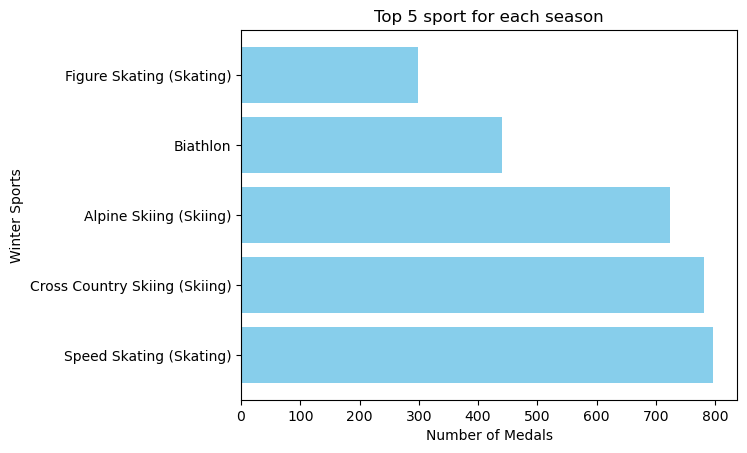

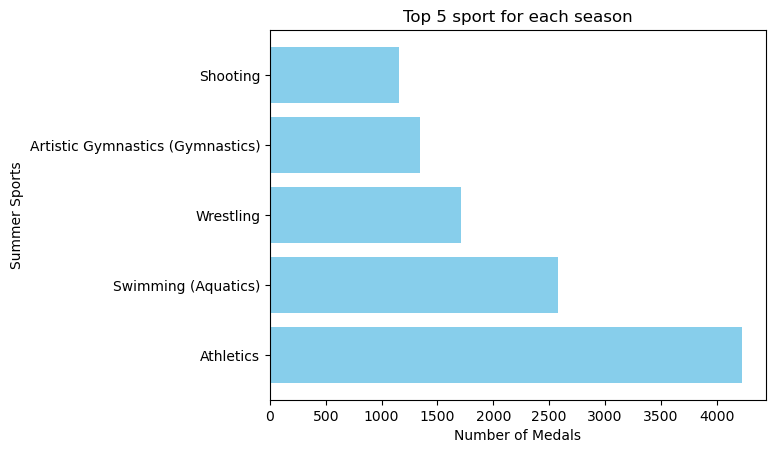

In [12]:
# count distinct medals per sport and season
medal_events = combined.drop_duplicates(['year', 'event', 'medal', 'type'])

count = medal_events.groupby(['sport', 'type'])['medal'].count().reset_index()

# find the sport with the most medals for each season
sport_top = count.loc[count.groupby('type')['medal'].idxmax()]

print("Top sports by season:")
print(sport_top)

# get top 5 sport for each season
for season in count['type'].unique():
    if season == "Winter":
        plt.ylabel('Winter Sports')
    else:
        plt.ylabel('Summer Sports')
        
    season_data = count[count['type'] == season].sort_values('medal', ascending = False)[:5]
    plt.barh(season_data['sport'], season_data['medal'], color = 'skyblue')
    plt.title('Top 5 sport for each season')
    plt.xlabel('Number of Medals')
    plt.gca()
    plt.show()



3. Height and Weight Outliers - Did they win more events?

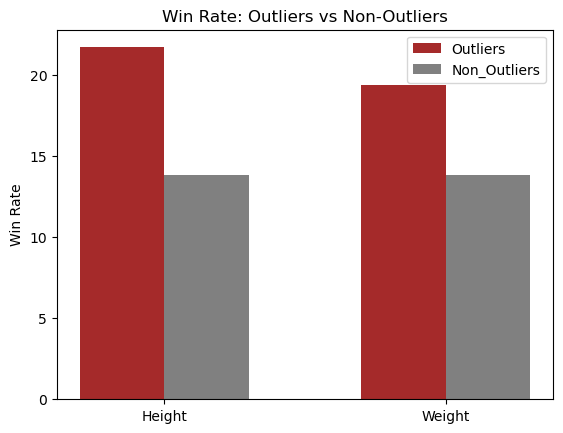

,Category,Outlier Win Rate,Non-outlier Win Rate,Difference(%)
0,Height,21.71,13.85,7.87
1,Weight,19.36,13.80,5.56


In [13]:
# 3. checking for Height outliers

Q1 = combined['height_cm'].quantile(0.25)
Q3 = combined['height_cm'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

height_outliers = combined[(combined['height_cm'] < lower_bound) | (combined['height_cm'] > upper_bound)]

# checking for weight outliers

Q1_w = combined['weight_kg'].quantile(0.25)
Q3_w = combined['weight_kg'].quantile(0.75)

IQR_w = Q3_w - Q1_w

lower_bound_w = Q1_w - 1.5 * IQR_w
upper_bound_w = Q3_w + 1.5 * IQR_w

weight_outliers = combined[(combined['weight_kg'] < lower_bound_w) | (combined['weight_kg'] > upper_bound_w)]

'''
Comparing with winners: 
 1. We keep the height and weight outliers athletes and from the dataframe, we choose only those have have won a medal.
 2. non_outlier = a clean dataset without any height or weight outliers
 3. normal_winners = from the non_outlier dataset, we pick those who have won a medal. 
 4. Lastly, we calculate the win rate for both the height and the weight 
'''
height_outliers_winners = height_outliers[height_outliers['medal'].isin(['Gold', 'Silver', 'Bronze'])]
non_outlier = combined[~combined.index.isin(height_outliers.index)]
normal_winners = non_outlier[non_outlier['medal'].isin(['Gold', 'Silver', 'Bronze'])]

weight_outliers_winners = weight_outliers[weight_outliers['medal'].isin(['Gold','Silver','Bronze'])]
non_outlier_w = combined[~combined.index.isin(weight_outliers.index)]
normal_winners_w = non_outlier_w[non_outlier_w['medal'].isin(['Gold', 'Silver', 'Bronze'])]

Height_Outlier_win_rate =  (len(height_outliers_winners) / len(height_outliers))*100
Height_NonOutlier_win_rate = (len(normal_winners) / len(non_outlier))*100
Weight_Outlier_win_rate = (len(weight_outliers_winners) / len(weight_outliers))*100
Weight_NonOutlier_win_rate = (len(normal_winners_w) / len(non_outlier_w))*100

# converting our data to a table
data = {
    'Category' : ['Height', 'Weight'],
    'Outlier Win Rate' : [Height_Outlier_win_rate, Weight_Outlier_win_rate],
    'Non-outlier Win Rate' : [Height_NonOutlier_win_rate, Weight_NonOutlier_win_rate],
    'Difference(%)' : [(Height_Outlier_win_rate - Height_NonOutlier_win_rate), (Weight_Outlier_win_rate - Weight_NonOutlier_win_rate)]
}

win_table = pd.DataFrame(data)   
ans = win_table.round(2)

# Plotting the graph 
metrics = ['Height', 'Weight']
outlier_rates = [Height_Outlier_win_rate, Weight_Outlier_win_rate]
non_outlier_rates = [Height_NonOutlier_win_rate, Weight_NonOutlier_win_rate]

x = range(len(metrics))
plt.bar(x, outlier_rates, color = 'brown', width = 0.3, label = 'Outliers')
plt.bar([i+0.3 for i in x], non_outlier_rates, color = 'grey', width = 0.3, label = 'Non_Outliers')
plt.title('Win Rate: Outliers vs Non-Outliers')
plt.ylabel('Win Rate')
plt.xticks([i+0.15 for i in x], metrics)
plt.legend()
plt.show()

ans

### Participation & Popularity
- Football and Ice Hockey dominate in terms of athlete participation and medal counts.
- The more athletes and events a sport has, the more opportunities to win, making it appear more “successful.”

### Physical Attributes Advantage
- Taller athletes had a 7.9% higher win rate, and heavier athletes had a 5.6% higher win rate compared to non-outliers.
- This proves that in certain sports (athletics, throwing, long jump, etc.), body structure gives athletes a natural competitive edge.

### Season & Suitability
- Summer dominance → Athletics & Swimming (body movement–driven sports, where training is more accessible globally).
- Winter dominance → Skating & Skiing (sports dependent on geography and climate).

### Observation: The most successful sports are those that:
- Have high global participation (many events, many athletes).
- Align with optimal physical attributes for performance.
- Fit the climate/season, making them sustainable for training and competition.

That’s why Athletics and Football dominate the Summer Olympics, while Skating and Skiing dominate the Winter Olympics.

### Part 2: The role of age in performance

5. How has the average age of medalists changed by each decade?

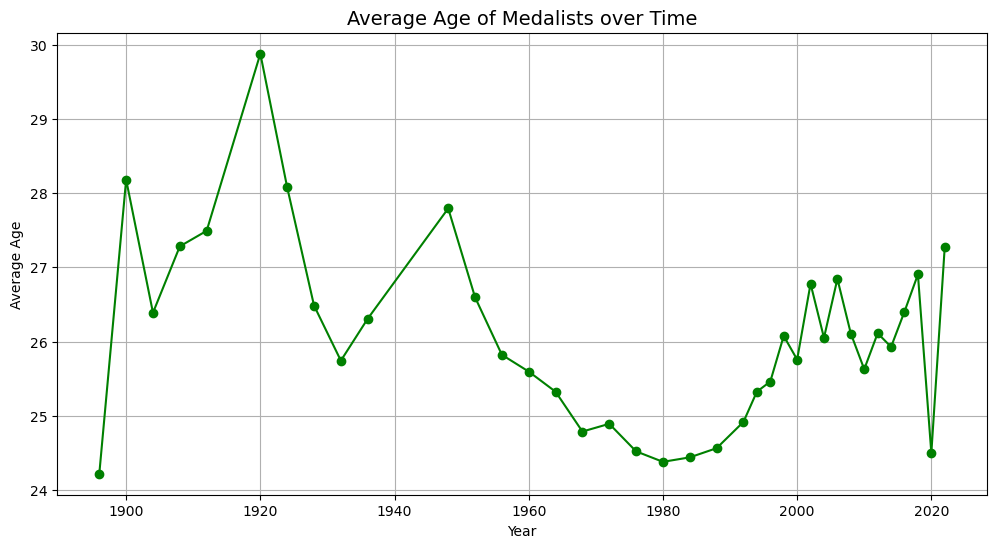

In [14]:
# 5. we have to add a column that defines age of the athletes in the year that the competed

combined['Age_of_Competition'] = np.where(
    (combined['year'] == 0) | (combined['birth_year'] == 0),
    -1,
    combined['year'] - combined['birth_year']
)

# valid ages: only keep realistic competition ages
valid_data = combined[
    (combined['year'] > 0) &
    (combined['Age_of_Competition'] > 15 ) & 
    (combined['Age_of_Competition'] < 60)  
]

avg_age_year = valid_data.groupby('year')['Age_of_Competition'].mean().reset_index()

plt.figure(figsize=(12,6))
plt.plot(avg_age_year['year'], avg_age_year['Age_of_Competition'], marker ='o', color ='green')
plt.title('Average Age of Medalists over Time', fontsize = 14)
plt.xlabel('Year')
plt.ylabel('Average Age')
plt.grid(True)
plt.show()




### The average age of Olympic medalists has shown some variation across decades:
- In the 1890s, athletes were generally the youngest, averaging around 25 years old.
- By the 1920s, the trend shifted upward, with the highest average age touching nearly 30 years old.

- Across other decades, the age fluctuated but consistently centered around 27 years, which appears to be the biological “peak” performance age for Olympic athletes.
  
- This observation aligns with external studies analyzing Olympic track and field data, which also identified 27 years as the median peak performance age.
  
- The fact that Athletics dominates the Summer Olympics—and has the highest medal counts—further reinforces this age clustering, as most medalists in Athletics reach their prime during their mid to late 20s

While athlete ages have shifted slightly between decades, the overall pattern confirms that the mid-to-late 20s is the prime age for Olympic success, with the 1920s being the notable outlier where average medalist age peaked close to 30.

### Part 3: Longevity & Consistency

6. How do repeat athletes perform over multiple olympics?

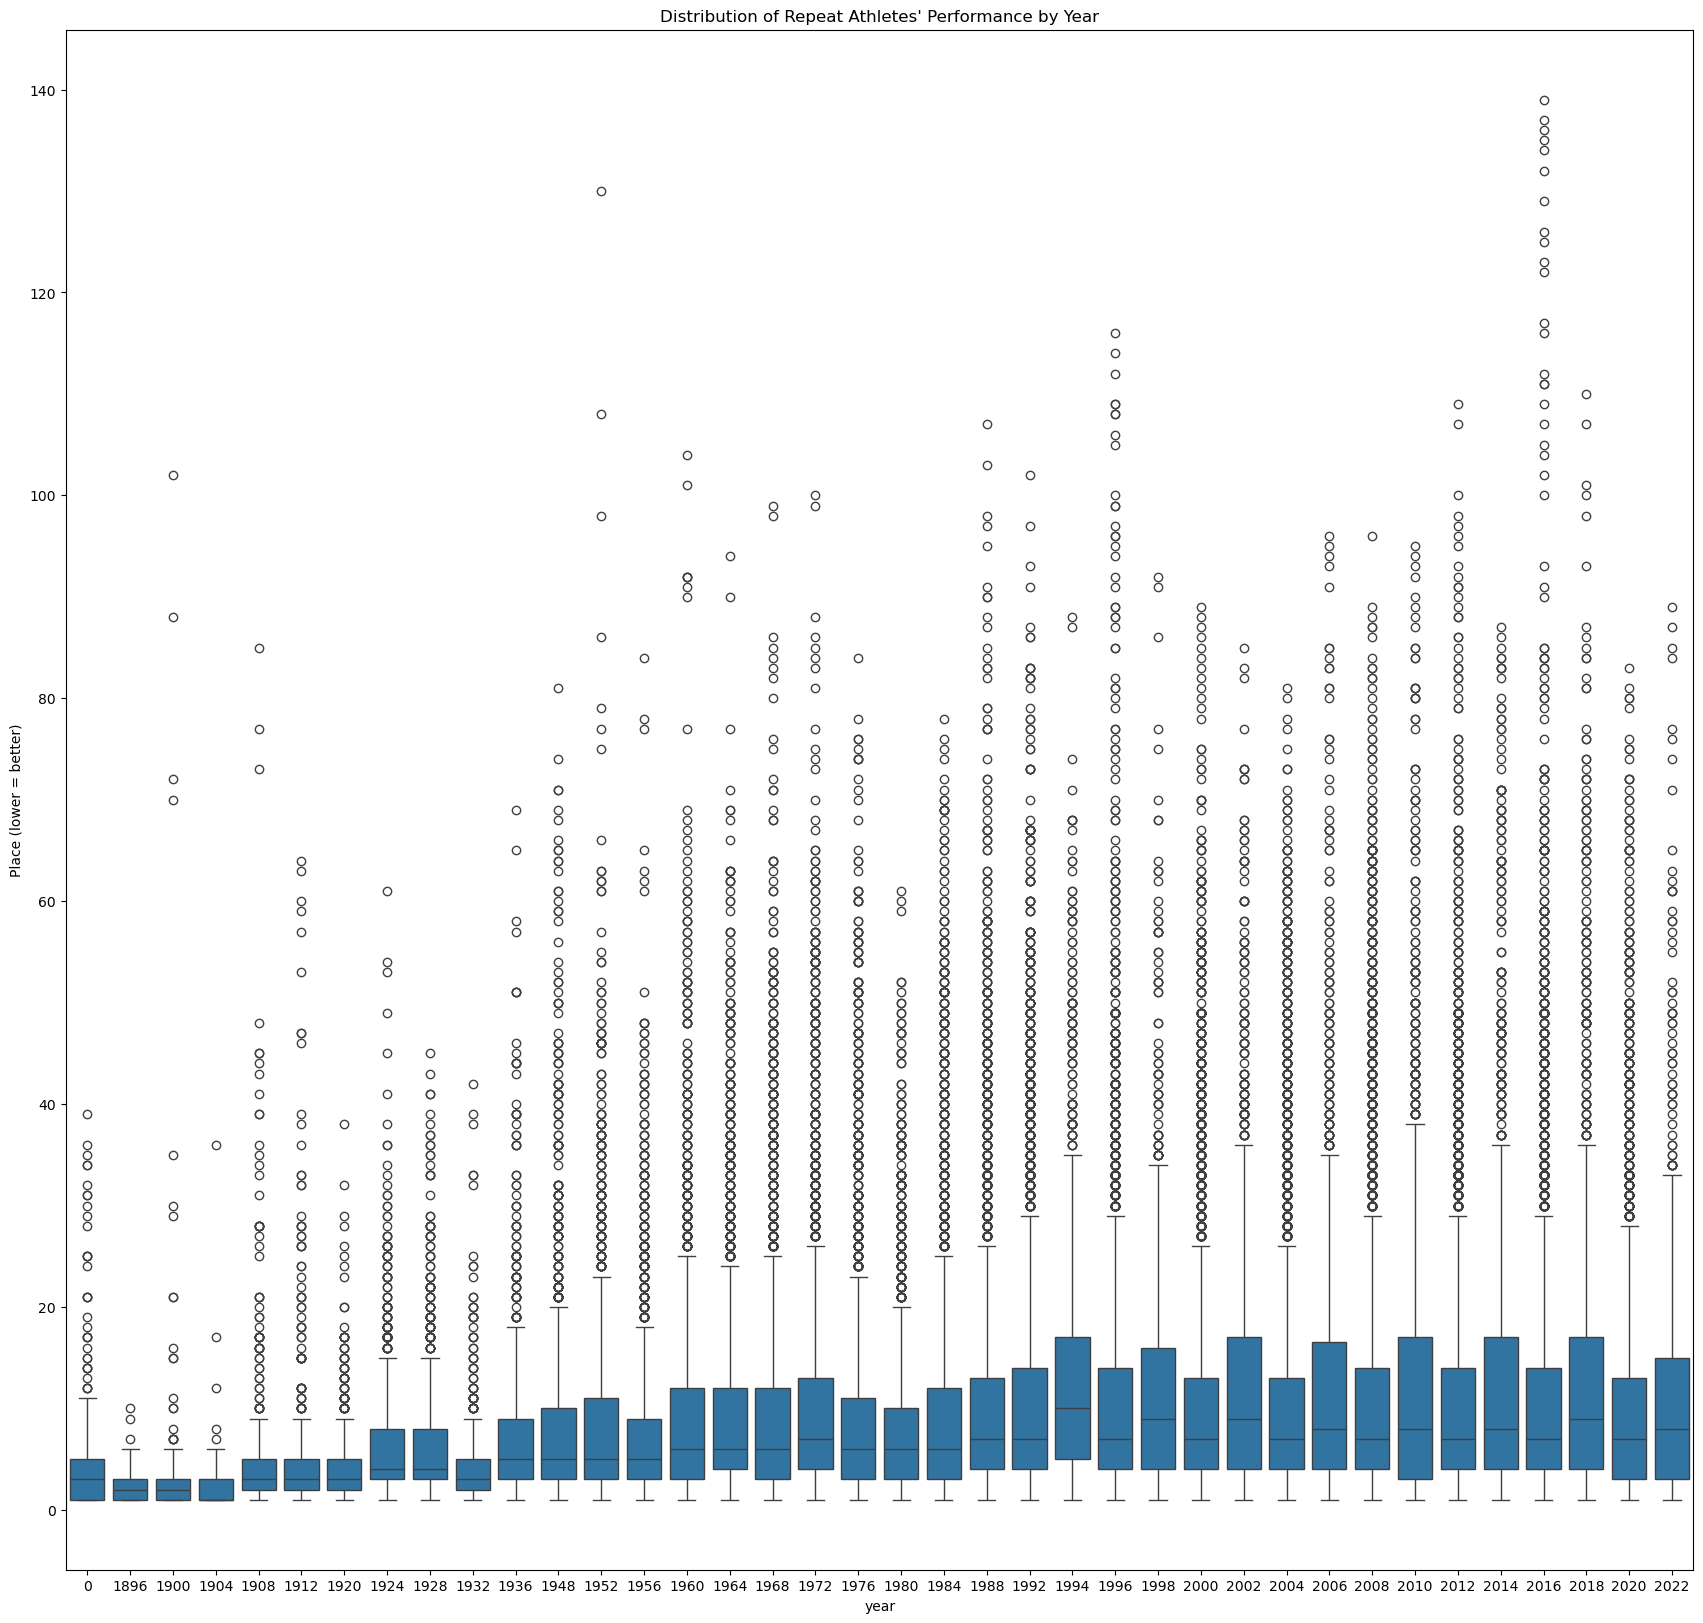

In [15]:
# 6. identify repeat athletes
repeat_athletes =  combined.groupby('name')['year'].nunique().reset_index()
repeat_athletes = repeat_athletes[repeat_athletes['year'] > 1]

# getting all the data of repeat athletes
repeat_winners = combined.merge(
    repeat_athletes[['name']], on='name', how='inner'
)[['name', 'year', 'sport', 'event', 'medal','place']]


plt.figure(figsize=(21,20))

# taking the best place per year per athlete 
best_place_per_year = repeat_winners.groupby(['name','year'])['place'].min().reset_index()
sns.boxplot(data=best_place_per_year, x='year', y='place')

plt.ylabel("Place (lower = better)")
plt.title("Distribution of Repeat Athletes' Performance by Year")
plt.show()


7. Does sport type affect athlete lifespan?

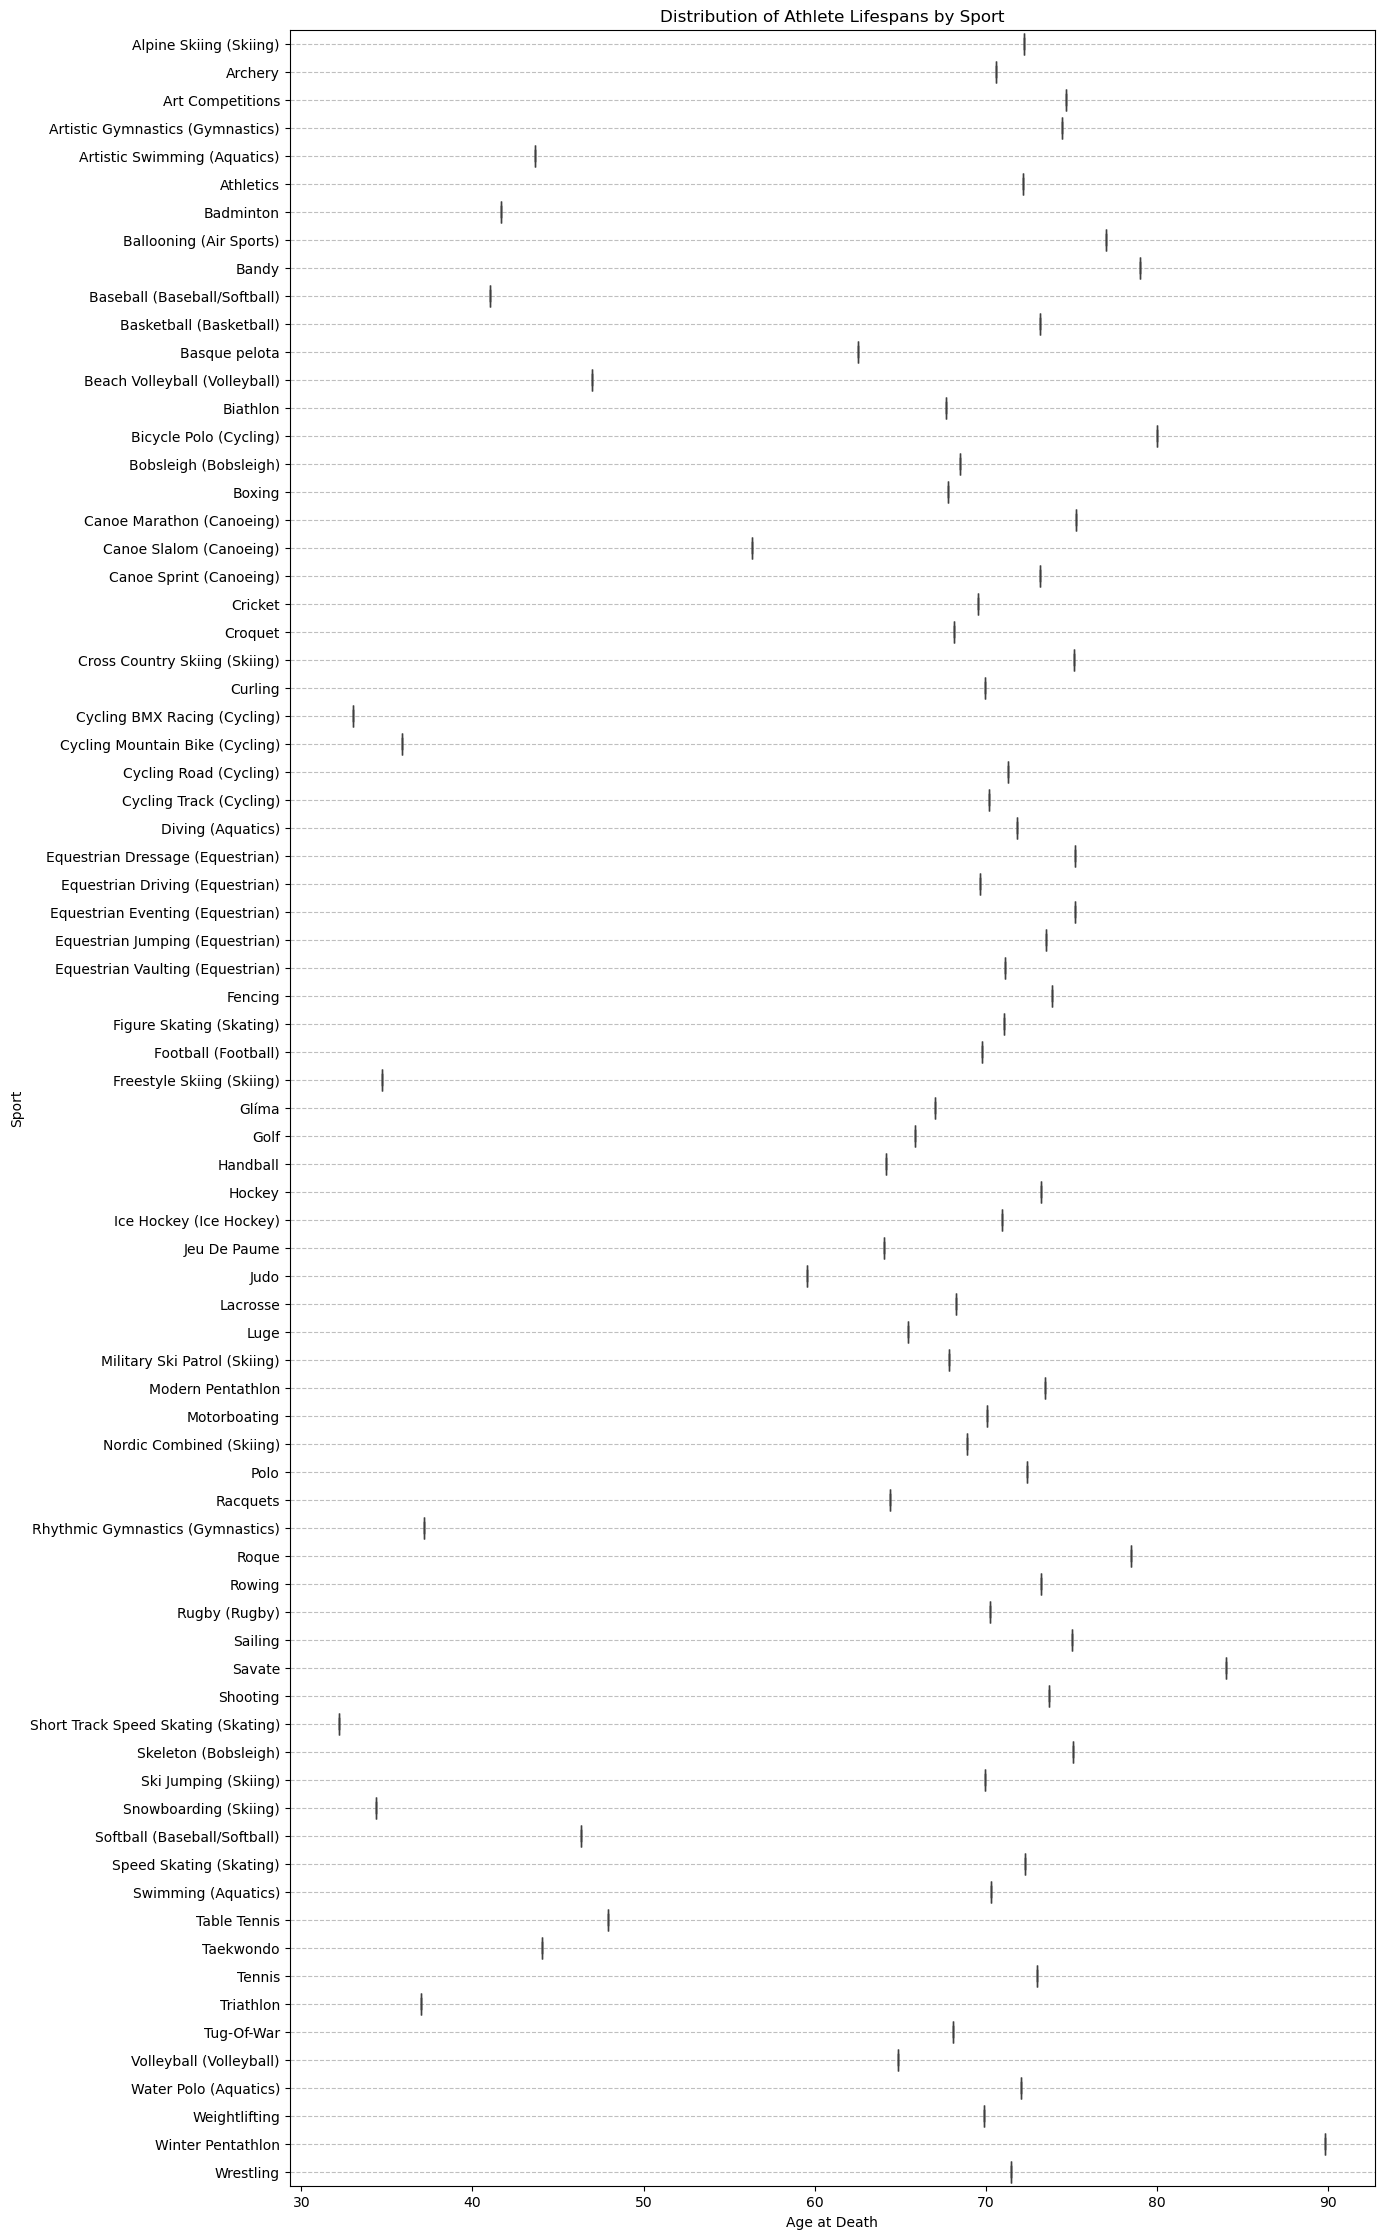

In [16]:
# 7.
valid_results = combined[
    (combined['sport'].notna()) &
    (combined['birth_year'].notna()) &
    (combined['death_year'].notna()) &
    (combined['birth_year'] > 0) &
    (combined['death_year'] > 0)
].copy()

valid_results['lifespan'] = valid_results['death_year'] - valid_results['birth_year']

lifespan_by_sport = valid_results.groupby('sport')['lifespan'].mean().reset_index()

lifespan_by_sport.sort_values('lifespan', ascending = False)

plt.figure(figsize=(14, 28))
sns.boxplot(
    data=lifespan_by_sport, 
    y='sport', 
    x='lifespan', 
    hue='sport',   # assign y variable to hue
    dodge=False,   # prevent splitting boxes
    legend=False   # remove extra legend
)
plt.xlabel('Age at Death')
plt.ylabel('Sport')
plt.title('Distribution of Athlete Lifespans by Sport')
plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.show()

### Repeat Athletes’ Performance:
- Early Olympics (till 1940s): repeat athletes clustered in top 1–5 ranks.
- After 1950s: range widened, with outliers reaching beyond 100th place (peaking around 140th in 2016).
- Median consistently remained between 1st–3rd place, proving that repeat athletes usually sustain medal-winning form.

### Lifespan by Sport:
- Average athlete lifespan ≈ 70 years, higher than global average.
- Winter Pentathlon athletes had the longest life expectancy (~90 years), possibly linked to endurance training and active lifestyle.

Repeat athletes show both longevity in career success and health advantages beyond sports, indicating that consistent training builds not only medals but also longer lifespans.

### Part 4: Countries and Dominance

8. Are some countries most successful in certain sports?


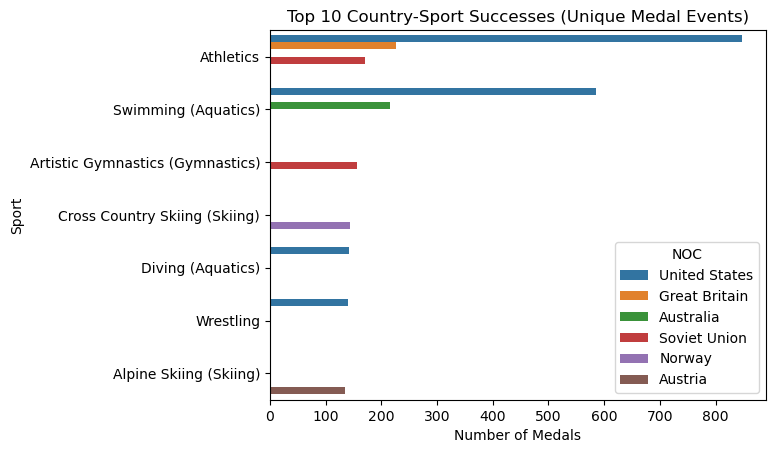

In [17]:
# 8️⃣ Grouping medals by NOC and sport (corrected)

# 1. Keep only medal winners
winners = combined[combined['medal'].isin(['Gold','Silver','Bronze'])]

# 2. Drop duplicates so each medal event counts only once per NOC per sport
unique_medals = winners.drop_duplicates(
    subset=['year', 'event', 'medal', 'sport', 'NOC']
).copy()  

# 3. Handle multi-NOC entries (split and explode)
unique_medals['NOC'] = unique_medals['NOC'].str.split(',')
unique_medals = unique_medals.explode('NOC')

# 4. Group by NOC and sport
success = unique_medals.groupby(['NOC','sport'])['medal'].count().reset_index()

# 5. Sort by total medals
success = success.sort_values(by='medal', ascending=False)

# 6. Plot top 10
top10 = success.head(10)
sns.barplot(data=top10, x='medal', y='sport', hue='NOC')
plt.title("Top 10 Country-Sport Successes (Unique Medal Events)")
plt.xlabel("Number of Medals")
plt.ylabel("Sport")
plt.show()


9. How has performance shifted in Summer vs. Winter Olympics over decades?

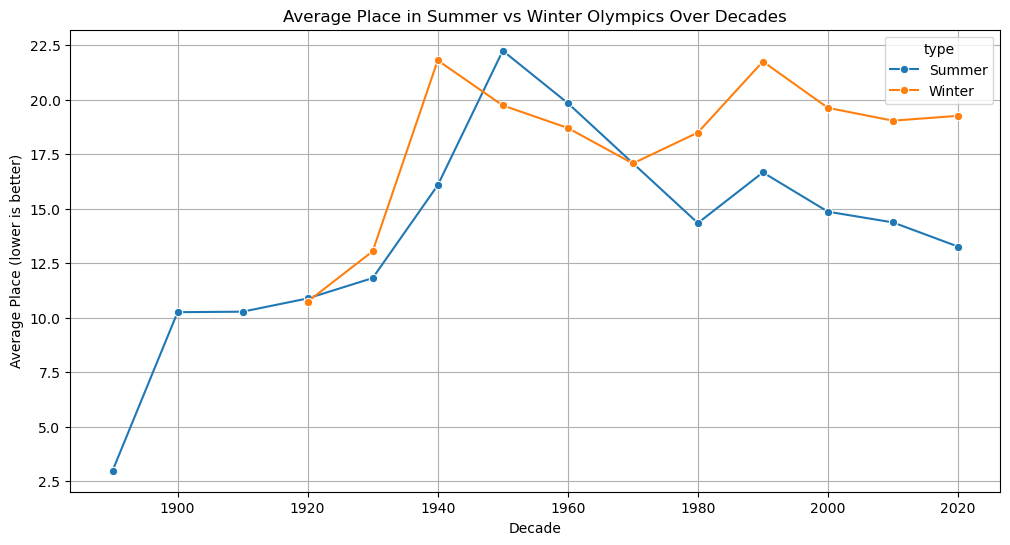

In [18]:
# 9.
valid_place_data = combined[
    (combined['place'].notna()) & 
    (combined['place'] > 0) & 
    (combined['year'] > 0)
]

valid_place_data = valid_place_data.copy()

valid_place_data['decade'] = (valid_place_data['year'] // 10) * 10

performance_by_decade = valid_place_data.groupby(['type', 'decade'])['place'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=performance_by_decade, x='decade', y='place', hue='type', marker='o')
plt.title('Average Place in Summer vs Winter Olympics Over Decades')
plt.ylabel('Average Place (lower is better)')
plt.xlabel('Decade')
plt.grid(True)
plt.show()



### Country dominance
- USA → Athletics, Swimming, Diving, Wrestling
- Soviet Union → Gymnastics
- Norway → Cross-country skiing
- Austria → Alpine skiing

### Insight: Success often reflects culture, training, and geography.

### Performance trends
- Summer Olympics: Rose (1880s–1950s), dipped in 1980s, steady since (~13th place today vs 3rd in 1890s).
- Winter Olympics: Climbed alongside Summer but ~4 places behind since 1980s (2020 → Summer 13th, Winter 19th).


Countries excel in sports aligned with environment and resources.
Summer remains slightly stronger overall; Winter reflects limited global access.

# Conclusion 

## The Olympic data reveals that success in sports is not random—it is shaped by participation, physical attributes, age, and country-specific advantages.

### Participation & Events:
- Sports with more events and global reach (Athletics, Football) naturally dominate medal counts.

### Biology: 
- Peak athletic performance clusters around age 27, with taller/heavier outliers excelling in specific events.

### Consistency: 
- Repeat athletes prove that long-term training sustains top performance and contributes to longer lifespans.

### Geography & Culture: 
- Countries dominate where climate, resources, and culture align with a sport (e.g., Norway in skiing, USA in athletics).


Overall, a sport is “successful” when it attracts high participation, aligns with optimal physical/biological traits, and is backed by strong cultural or national support.

In [20]:
combined.to_csv("combined_clean.csv",index=False)